# Notebook description

This notebook explores the possibility of predicting the fraction of checkins a business receives during weekends, based on the associated business categories, and on the business neighborhood and postal code. 

Originally, I thought it would be a good idea to try to predict the total number of checkins, or the number of checkins per month (one could think of the usefulness of such prediction when planning where to open a certain kind of business).

However, due to the lack of temporal information regarding checkins and/or businesses, we cannot know how old a given business is, so the raw numbers of checkings are not comparable among businesses. Predicting the fraction of checkings that occur during the weekend does not have this problem.  

The notebook is divided in two parts. In the first part, I read the businesses data and prepare the features table. In the second part, I combine the features table with the target values, I split labeled data into training and testing datasets, I tune a ridge regressor and I estimate its generalization performance. 

# Imports

In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Params

In [2]:
# Paths
businesses_path = '../data/businesses.csv'
businesses_proc_path = '../data/businesses_proc.csv'
generated_checkins_path = '../data/checkins.csv'

random_state = 0
test_size = 0.33

# Prepare data

Read businesses data

In [3]:
bs = pd.read_csv(businesses_path)

Keep just Toronto businesses (mainly for speed reasons)

In [4]:
bs = bs[bs.city== 'Toronto']

Data contains 3 rows with categories=NaN. Let us simply drop those.

In [5]:
bs.dropna(subset=['categories'], inplace=True)

Create a dataframe with a column per category appearing in the categories column

In [6]:
cat_df = bs['categories'].apply(lambda x: pd.Series(dict([(e.strip(), True) for e in x.split(',')])))

Quick check: how many businesses have each of the categories?

In [7]:
cat_counts = cat_df.sum().sort_values(ascending=False)

<IPython.core.display.Javascript object>


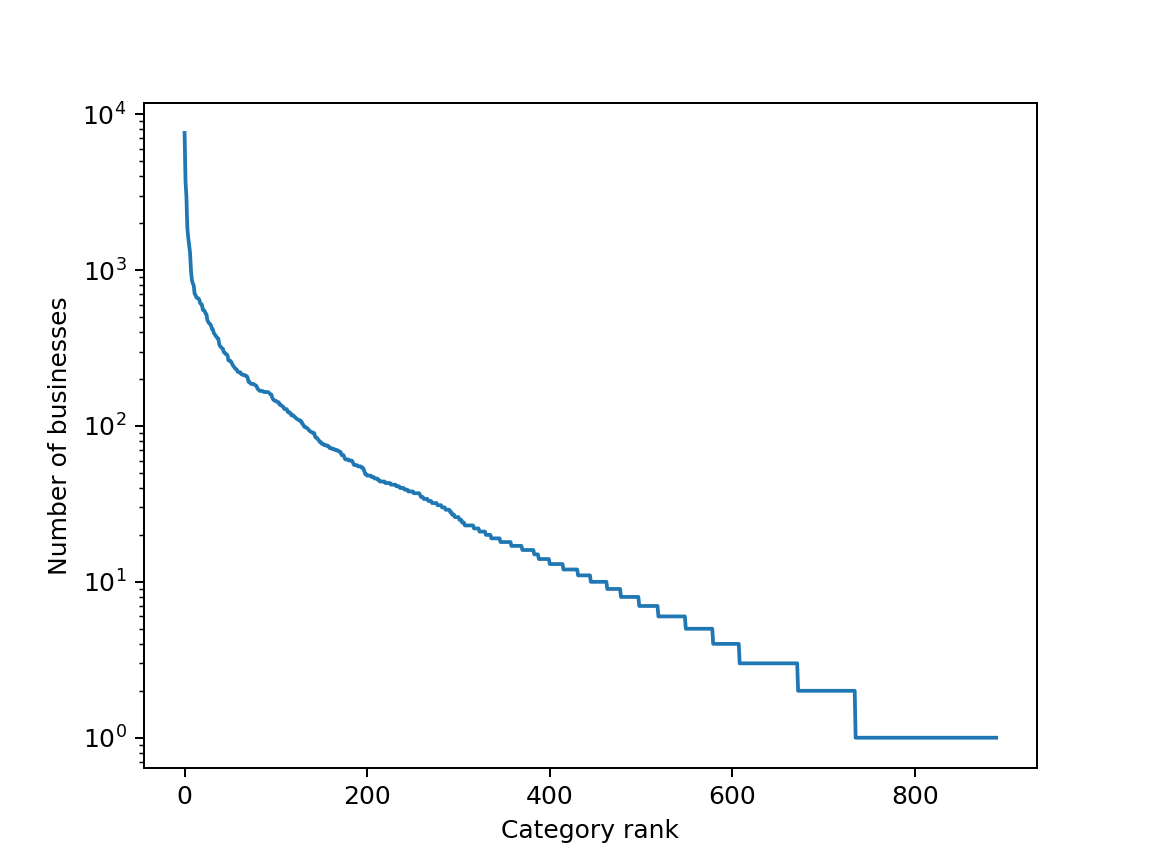

Text(0,0.5,'Number of businesses')

In [8]:
%matplotlib notebook
plt.plot(cat_counts.values)
plt.yscale('log')
plt.xlabel('Category rank')
plt.ylabel('Number of businesses')

The plot above shows that many categories appear only in a few businesses. Let us drop those categories to reduce the dimensionality of the final feature space:

In [9]:
cat_df = cat_df[cat_counts[cat_counts >= 10].index.values.tolist()]

Add categories columns

In [10]:
bs = pd.concat([bs.drop(['categories'], axis=1), cat_df], axis=1).fillna(0)

Add neighborhood dummy columns

In [11]:
bs = pd.get_dummies(bs, columns=['neighborhood'], dummy_na=True)

Add postal code categorical columns (only for those postal codes with more that a certain number of businesses)

In [12]:
postal_codes_df = pd.get_dummies(bs[['business_id', 'postal_code']], columns=['postal_code'], dummy_na=True)
postal_codes_counts = bs.postal_code.value_counts(dropna=False)
postal_codes_df = postal_codes_df[['postal_code_' + str(c) for c in (
    postal_codes_counts[postal_codes_counts >= 15].index.values.tolist())]]
bs = pd.concat([bs.drop(['postal_code'], axis=1), postal_codes_df], axis=1).fillna(0)

Save features

In [13]:
bs.to_csv(businesses_proc_path, index=False)

# Train and test model

Our goal is to approximate the function that maps _feature_ vectors to fraction of weekend checkins (the _target_ variable).

The fraction of weekend checkins is a continuos variable, so this is a _regression_ problem. 

Our learning algorithm will try to fit a certain model to the training data. That is, based on the relation between the features and the target on the training instances, it will try to adjust certain model parameters so the model captures that relation.

Read features and checkins info

In [27]:
bs = pd.read_csv(businesses_proc_path)
checkins = pd.read_csv(generated_checkins_path)

Get the total number of checkins (week + weekend) and the fraction of weekend checkins

In [15]:
checkins['total'] = checkins[['weekends', 'week']].sum(axis=1)
checkins['fracc_weekends'] = checkins.weekends / checkins.total

Keep only businesses with a reasonable number of checkins

In [16]:
checkins = checkins[checkins.total >= 30]

Finally, keep just columns business_id and frac_weekends

In [17]:
checkins = checkins[['business_id', 'fracc_weekends']]

Merge relevant columns from the features table with the ground truth in checkins

In [18]:
bs.drop(['address', 'attributes', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name',
         'review_count', 'stars', 'state'], axis=1, inplace=True)
bs = bs.merge(checkins, on='business_id')
bs.replace({'False': 0, 'True': 1}, inplace=True)

Split into train and test

In [19]:
tr, te = train_test_split(bs, test_size = test_size, random_state = random_state)

Define pipeline. I use a __Ridge__ regressor here. This is a very basic model, that simply adds a regularization term to classic linear regression. It is a _linear_ model. This means that if the underlying function we are trying to approximate (the function that maps features to fractions of weekend checkins) is highly non linear (i.e the fraction of weekend checkins does not vary linearly with the features), the approximation might not be good. However, this models are simple to train, and it is usually a good idea to try them first to get an initial attempt. 

For the training algorithm to work, training features must be free of nans. We will impute missing values in a given column with the median for that column (features should not have nans at this point anyway)

Also, linear models tend to work much better when the different features are in the same scale (If column A contains values an order of magnitued larger than values of column B, changes in B might seem irrelevant to the linear function $w_A * A + w_B * B$). We therefore satandarize each column (that is, we substract the column mean and divide by the column standard deviation). We are using only 1-0 features here, so this should not be necesary anyway. 

We assemble all three steps (imputing, scaling and the ridge regressor) in a pipeline. This is extremly useful for organizing the train-validation-test regime, as we will se below.

In [20]:
pipeline = Pipeline([('imputer', Imputer(strategy='median')), 
                     ('scaler', StandardScaler()), ('rgs', Ridge())])

Every machine learning model has a certain set of hyper-parameters that need to be chosen to univocally define the model. 

Ridge has only one hyper-parameter that is relevant to us for this problem: the weight of the regularization term. Regularization is a topic in its own. Let's just say that regularization controls how well the trained model will fit the trained data. Less regularization will result in models that fit the training data "too well", possibly capturing artifacts do to noise or sampling (training in data is just a sample of underlying distributions that we are trying to model). Such _overfitted_ models won't _generalize_ well (they won't behave as the underlying mapping function on data not present in the training set)

To choose the right value of the reguarization weight, we perform a grid search.

In [21]:
alpha_range = np.array([10, 1, 0.1, 0.01, 0.001, 0.0001, 0])
grid = {'rgs__alpha':alpha_range}
ridge_gs = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error', cv = 5, verbose=10)

Calling $fit$ on the grid search will compute a certain performance measure for each combination of values in the arrays in $grid$ (i.e., for each point in the grid). The combination of values that give the best performance will be chosen as the optimal hyper-parameter set. 

How is this performance measure computed for each point in the grid? By n-fold cross-validation. Specifically, the training set is splitted into as many (equally sized) parts as stated by the variable _cv_ above and, for each possible combination of _cv_ - 1 parts, the pipeline is trained on the set made of those _cv_ - 1 parts and tested on the remaining part. Testing involves using the trained pipeline to _predict_ a value for eaach test vector on the test part. After obtaining a prediction for each vector, a score is computed for the test part by comparing the predictions and the true values (in our case, the actual value in the _fracc weekends_ column). The performance for a given grid point is obtained by averaging the score of the different test parts. Note that the whole pipeline (imputer, scaler and regressor) is trained each time on the selected _cv_ - 1 parts and tested on the remaining part. That is, not only the parameters of the Ridge regressor are adjusted during each training step: the median (for the imputer) and the mean and standard deviation (for the scaler) are also computed, and then applied to preprocess the test part before applying the trained regressor. Sklearn framework makes this plumbing really easy. 

The specific scoring function is indicated by the parameter $scoring$. In this case, I have chosen the _mean absolute error_ or _MAE_. This is just the average over the test part of the absolute differences between the prediction and the true value. We have chosen MAE because it shows errors in the same units as the fraction of weekend checkins (as opposed to, for example, the _coefficient of determination_). Among the alternatives, we could have also used (for example) _mean suqared error_ (_MSE_). _MSE_ tends to give higher weight to large errors (because of the squared differences), and its interpretation is more involved than that of _MAE_. In any case, most of the mentioned scoring functions would probably give similar results in terms of model selection.

In [22]:
ridge_gs.fit(tr.drop(['business_id', 'fracc_weekends'], axis=1), tr.fracc_weekends)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] rgs__alpha=10.0 .................................................
[CV] ........... rgs__alpha=10.0, score=-0.103710982831, total=   0.8s
[CV] rgs__alpha=10.0 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ........... rgs__alpha=10.0, score=-0.103411572204, total=   0.8s
[CV] rgs__alpha=10.0 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] ............ rgs__alpha=10.0, score=-0.10347011027, total=   0.6s
[CV] rgs__alpha=10.0 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s


[CV] ........... rgs__alpha=10.0, score=-0.104287589818, total=   0.6s
[CV] rgs__alpha=10.0 .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s


[CV] ........... rgs__alpha=10.0, score=-0.100228612134, total=   1.2s
[CV] rgs__alpha=1.0 ..................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s remaining:    0.0s


[CV] ............ rgs__alpha=1.0, score=-0.103900371881, total=   0.8s
[CV] rgs__alpha=1.0 ..................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.0s remaining:    0.0s


[CV] ............ rgs__alpha=1.0, score=-0.103680979185, total=   0.8s
[CV] rgs__alpha=1.0 ..................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.0s remaining:    0.0s


[CV] ............ rgs__alpha=1.0, score=-0.103790087115, total=   0.6s
[CV] rgs__alpha=1.0 ..................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.8s remaining:    0.0s


[CV] ............ rgs__alpha=1.0, score=-0.104696971889, total=   0.6s
[CV] rgs__alpha=1.0 ..................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.6s remaining:    0.0s


[CV] ............ rgs__alpha=1.0, score=-0.100505088975, total=   0.6s
[CV] rgs__alpha=0.1 ..................................................
[CV] ............ rgs__alpha=0.1, score=-0.103920291359, total=   0.6s
[CV] rgs__alpha=0.1 ..................................................
[CV] ............ rgs__alpha=0.1, score=-0.103710331271, total=   0.6s
[CV] rgs__alpha=0.1 ..................................................
[CV] ............ rgs__alpha=0.1, score=-0.103826552816, total=   0.6s
[CV] rgs__alpha=0.1 ..................................................
[CV] ............ rgs__alpha=0.1, score=-0.104740735381, total=   0.8s
[CV] rgs__alpha=0.1 ..................................................
[CV] ............ rgs__alpha=0.1, score=-0.100534687982, total=   0.9s
[CV] rgs__alpha=0.01 .................................................
[CV] ........... rgs__alpha=0.01, score=-0.103922294059, total=   0.7s
[CV] rgs__alpha=0.01 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   33.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rgs', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rgs__alpha': array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=10)

Estimate generalization performance on the test set

In [23]:
mae_test_model = -ridge_gs.score(te.drop(['business_id', 'fracc_weekends'], axis=1), te.fracc_weekends)
print('Ridge regressor mean MAE on the test set: {:.4}'.format(mae_test_model))

mae_test_baseline = mean_absolute_error(te.fracc_weekends, [tr.fracc_weekends.mean()] * te.shape[0] )
print('That is {:.4}% decrease compared to the baseline (predicting always the training set mean).'.format(
    100*(mae_test_baseline - mae_test_model)/mae_test_baseline ))

Ridge regressor mean MAE on the test set: 0.1016
That is 12.14% decrease compared to the baseline (predicting always the training set mean).


The descrease in MAE compared to the baseline looks rather small. It seems that the trained model should perform better (predicting always the training set mean is a really basic baseline). But we should bear in mind that MAE is just an average: it might very well be the case that the prediction is actually quite precise for many businesses, while bad for others, giving as a result a regular average. Let us take a look at the distribution of predicted weekend fractions and compare it with the distribution of weekend fractions in the test set:

<IPython.core.display.Javascript object>


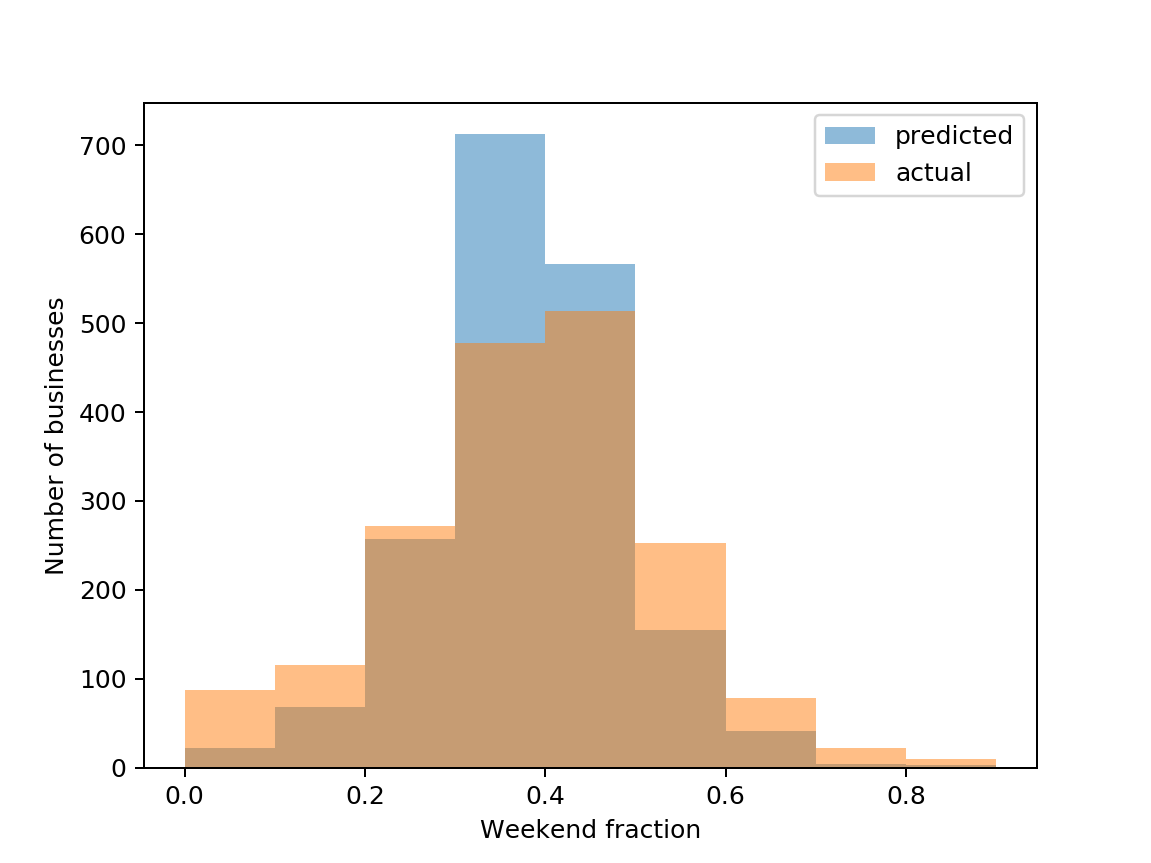

In [24]:
%matplotlib notebook
plt.hist(ridge_gs.predict(te.drop(['business_id', 'fracc_weekends'], axis=1)), 
         alpha=0.5, bins=np.arange(0,1,0.1), label='predicted')
plt.hist(te.fracc_weekends, alpha=0.5, bins=np.arange(0,1,0.1), label='actual')
plt.xlabel('Weekend fraction')
plt.ylabel('Number of businesses')
plt.legend()
plt.show()

We can observe the distributions are somehow similar. At the very least, it is clear that the model is not just predicting always something close to the train set mean. Let us for example compute the MAE for the top 20% better predicted businesses.

In [25]:
pred_act = pd.DataFrame({'predicted':ridge_gs.predict(te.drop(['business_id', 'fracc_weekends'], axis=1)), 
                         'actual': te.fracc_weekends})
pred_act['diff'] = abs(pred_act.predicted - pred_act.actual)
pred_act.sort_values('diff', inplace=True)
n_top_20 = int(pred_act.shape[0]*0.2)
pred_act = pred_act.iloc[:n_top_20, :]
mae_test_model_top20 = mean_absolute_error(pred_act.actual, pred_act.predicted)

print('Ridge regressor mean MAE on the top 20% better predicted businesses in the test set: {:.4}'.format(
    mae_test_model_top20))
mae_test_baseline_top20 = mean_absolute_error(pred_act.actual, [tr.fracc_weekends.mean()] * n_top_20)
print('That is {:.4}% decrease compared to the baseline (predicting always the training set mean).'.format(
    100*(mae_test_baseline_top20 - mae_test_model_top20)/mae_test_baseline_top20 ))

Ridge regressor mean MAE on the top 20% better predicted businesses in the test set: 0.01531
That is 77.32% decrease compared to the baseline (predicting always the training set mean).
